# **Expectation-Maximization algorithm** (hidden model)
### Author: Martí Cortada Garcia
---

In [1]:
# Import required libraries
import numpy as np
from Bio import SeqIO, Phylo
from io import StringIO
from collections import Counter, OrderedDict
import itertools
import pandas as pd
import math
import copy

### **Input:**
We have a tree $T$ (where the root corresponds to the internal node codified as `Int_0`) and the alignments of the leaves.

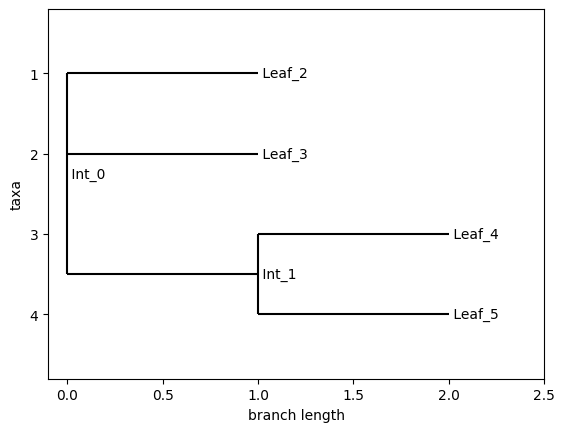

In [6]:
newick_tree = "(2:1,3:1,(4:1,5:1):1)"
tree = Phylo.read(StringIO(newick_tree), "newick")

# Change nodes names
for idx, clade in enumerate(tree.get_nonterminals()):
    clade.name = "Int_" + str(idx) if idx > 0 else "Int_0" 

# Change leaves names
for idx, clade in enumerate(tree.get_terminals()):
    clade.name = "Leaf_" + clade.name 

Phylo.draw(tree)

net = Phylo.to_networkx(tree) # to graph

In [7]:
from data_simulation import simulate

edges = simulate(net)

a -3.24739087945839
b 0
a -44.4778138583571
b 0
a -44.4778138583571
b 0
[-3.24739087945839, -44.4778138583571 - 18.2586886935172*I, -44.4778138583571 + 18.2586886935172*I]
a -0.0568327713490847
b 0
a -13.5463349122167
b 0
a -13.5463349122167
b 0
[-0.0568327713490847, -13.5463349122167 - 3.73884167824308*I, -13.5463349122167 + 3.73884167824308*I]
a -0.250498251024632
b 0
a -21.4354653121296
b 0
a -21.4354653121296
b 0
[-0.250498251024632, -21.4354653121296 - 2.59478567733291*I, -21.4354653121296 + 2.59478567733291*I]
a -0.634975349093416
b 0
a -14.7373209173138
b 0
a -14.7373209173138
b 0
[-0.634975349093416, -14.7373209173138 - 7.06266791837772*I, -14.7373209173138 + 7.06266791837772*I]
a -0.728940738708158
b 0
a -15.4335976738445
b 0
a -15.4335976738445
b 0
[-0.728940738708158, -15.4335976738445 - 7.51482109780971*I, -15.4335976738445 + 7.51482109780971*I]
a -0.241956088813282
b 0
a -11.9715027136526
b 0
a -11.9715027136526
b 0
[-0.241956088813282, -11.9715027136526 - 5.48429720842289

In [9]:
leave_alignments = [i for i in SeqIO.parse("4_leaves_1000length_sequences.fasta", "fasta")]
for i in leave_alignments:
    print("Seq>", i.seq)

Moreover, we codify the alphabet $\sum=\{A,G,C,T\}\to\{0,1,2,3\}$

In [10]:
leave_sequences = []
for i in leave_alignments:
    seq = ""
    for j in i.seq:
        if j == "A":
            seq += "0"
        elif j == "G":
            seq += "1"
        elif j == "C":
            seq += "2"
        elif j == "T":
            seq += "3"
        else:
            raise ValueError("Invalid nucleotide")
    leave_sequences.append(seq)

leave_sequences

[]

where the previous sequencies have been generated with the following parameters:

In [5]:
M_root_to_leaf2 = np.array([[0.67781054, 0.07466279, 0.1205998, 0.12692686], [0.08371281, 0.71004812, 0.08640399, 0.11983508], [0.0957915, 0.1044398,  0.71133383, 0.08843488], [0.11570591, 0.09873057, 0.0840438, 0.70151972]])
M_root_to_leaf3 = np.array([[0.68092156, 0.08546336, 0.10472156, 0.12889352], [0.08863481, 0.6951298 , 0.08641648, 0.12981891], [0.09464835, 0.09638309, 0.71981502, 0.08915354], [0.0833322, 0.09754567, 0.10675413, 0.71236799]])
M_root_to_node1 = np.array([[0.6592648 , 0.07939543, 0.11402445, 0.14731532], [0.09043177, 0.7000641 , 0.1164545 , 0.09304964], [0.0839887 , 0.09532453, 0.69092513, 0.12976165], [0.09255666, 0.11016143, 0.08501808, 0.71226383]])
M_node1_to_leaf4 = np.array([[0.67145996, 0.10410964, 0.10247415, 0.12195626], [0.11561701, 0.68456579, 0.11335696, 0.08646025], [0.09854579, 0.09659594, 0.71662829, 0.08822998], [0.08112586, 0.08950085, 0.12349954, 0.70587375]])
M_node1_to_leaf5 = np.array([[0.65363449, 0.07652442, 0.10482714, 0.16501394], [0.08349303, 0.69217288, 0.11542616, 0.10890792], [0.10121279, 0.10635535, 0.70522391, 0.08720795], [0.0945611 , 0.08778159, 0.10371737, 0.71393994]])

root_distribution = np.array([0.25, 0.25, 0.25, 0.25])

### **Step 0**: 
Initialise parameters

In [3]:
# Initialise estimation for the root distribution (all probabilities between 0.2 and 0.3)
def init_root_distribution():
    estimated_root_distribution = []
    while True:
        estimated_root_distribution = np.random.dirichlet([1,1,1,1])
        i = 0
        while i<4:
            if estimated_root_distribution[i] > 0.2 and estimated_root_distribution[i] < 0.3:
                i += 1
            else:
                break
        if i == 4:
            assert(np.sum(estimated_root_distribution) < 1.0000001 and np.sum(estimated_root_distribution) > 0.9999999)
            assert(estimated_root_distribution[i] > 0.2 and estimated_root_distribution[i] < 0.3 for i in range(4))
            break
    return estimated_root_distribution

estimated_root_distribution = init_root_distribution()

# Initialise estimation for the transition matrices (which we estimate as LARGE-DIAGONAL-VALUE matrices)
def init_transition_matrix():
    M = np.zeros((4,4))
    i=0
    while i<4:
        R = np.random.dirichlet([1,1,1,1])
        if R[i] > 0.6 and R[i] < 0.8:
            M[i,:] = R 
            i = i + 1
    assert (M[i,i] > 0.6 and M[i,i] < 0.8 for i in range(4))
    assert (np.sum(M[i,:]) < 1.0000001 and np.sum(M[i,:]) > 0.9999999 for i in range(4))
    return M


Define a `class` that stores the information for the given tree:

In [7]:
class Param:
    def __init__(self, edge, transition_matrix, alignment=None):
        self.edge = edge
        self.transition_matrix = transition_matrix
        self.alignment = alignment # it will only be placed in the leaves


In [8]:
PARAMS = dict()

for edge in net.edges():
    # If we are in a leaf, we need to specify the alignment
    iter_leaves = 0
    if edge[1].name.startswith("L"):
        new_edge = Param(edge, init_transition_matrix(), leave_alignments[iter_leaves].seq)
        iter_leaves += 1
    # Otherwise, are in internal nodes
    else:
        new_edge = Param(edge, init_transition_matrix())
    u = str(edge[0].name.split("_")[1])
    v = str(edge[1].name.split("_")[1])
    name = "M_" + u + "_to_" + v
    PARAMS[name] = new_edge

We check all the initialisation parameters:

In [9]:
for i in PARAMS.items():
    print(i[0])
    print("Edge:", i[1].edge)
    print("Transition matrix:\n", i[1].transition_matrix)
    print("Alignment:\n", i[1].alignment)
    print("---"*30)

M_0_to_2
Edge: (Clade(name='Int_0'), Clade(name='Leaf_2'))
Transition matrix:
 [[0.79012346 0.0300472  0.10769102 0.07213831]
 [0.22630453 0.65485235 0.04071413 0.07812899]
 [0.06140669 0.07830763 0.70895766 0.15132802]
 [0.07767297 0.09075877 0.18776243 0.64380583]]
Alignment:
 CTCAAGCCTCCGAGCGACAAGCTTCAACTAATCGGTCTGAGAACCCAATATATAATGTTGAACGAACCGATCAAATCTCCATCCTAACGGAACAATGATTTTGTCGCAGATTAAACATCAAAGGGGCGTAGGCAGTACTTGAGACAACCCCTCCCGTCGGTGCAACGTTAAGCAGCGTGCTGTGACCGACATTTACACTTACCTACAGCTTCACGATCGTGAATGTGGTCCGGTGGTTCAGGTCAGCGTCATTATGGGTCCCCACTCCCATCTTAATAACTCTGCCAGATATCCTGAACTTATAAGGAAAGATGATACTCGTATGGTCCGTTATTGTCACAATAGGCAGCAATTCACGCAATTGTTGTAGCACCCTTAAGAGGGAATAGGGAGAATGATCCCCTGAATGAGCTCAGTCTGTGTACGCCAGTTCCGTAGTGGAGTCTTACGCCAATGACAGGGACAACGCCCCATGATAGCCCCGGTCAACAAGCCTGGTTATTGGCTTATTGCATTCGTCCGCCAACCCCTAACGCCCGTTTGGTGGCTACACGGATAAATGATCAACAACCTAATGGGATCGTAAACCTGAGCGAGCTCCGGCGTCATCGGTCTCTTACTAACATATCACGTACTCCGTGCCTGGGAACCTAGGGGCTTTTTCTTATAGGTGATGCTGCCCCCCACTGAAAGAGCGTCACATATCACACTCATTTTTCT

### **E-step**:
Define the *expected hidden data matrix* $U$, where $u_{i,j}=u_i\frac{f_{i,j}(\theta)}{\sum_{j=1}^m f_{i,j}(\theta)}=\frac{u_i}{f_i(\theta)}f_{i,j}(\theta)$.

In [10]:
# Obtain number of leaves and internal nodes
n_leaves, n_int = 0, 0 
for node in net.nodes():
    if node.name.startswith("L"):
        n_leaves += 1
    else:
        n_int += 1

# Count all the leaves ocurrences 
sequence_length = len(leave_sequences[0])
number_of_sequences = len(leave_sequences)
occurrences = []
for i in range(sequence_length):
    _ = ''
    for j in range(number_of_sequences):
        _ += leave_sequences[j][i]
    occurrences.append(_)
c = Counter(occurrences)
u_i = OrderedDict(sorted(c.items()))

# Define all possible (hidden) states of the internal nodes 
hidden_combinations = itertools.product([0,1,2,3], repeat=n_int)
sorted_hidden_combinations = sorted(hidden_combinations)
for i in range(len(sorted_hidden_combinations)):
    sorted_hidden_combinations[i] = ''.join([str(s) for s in sorted_hidden_combinations[i]])
 
# Define all possible fully observed states (i.e. combining u_i + internal nodes)
# '000000' would mean to have an 'A' in all nodes: Int_0, Int_1, Leaf_2, Leaf_3, Leaf_4, Leaf_5 
states = list(itertools.product(list(sorted_hidden_combinations), list(u_i.keys())))
states = [i[0]+i[1] for i in states]

In [171]:
# Define the expected hidden data matrix
U = dict()
params = PARAMS

for obs in states:
    U[obs] = u_i[obs[n_int:]] # initialise by computing u_i of the expected hidden data matrix formula
    f_ij = estimated_root_distribution[int(obs[0])] 
    for p in params.items():
        u, v = int(p[1].edge[0].name.split("_")[1]), int(p[1].edge[1].name.split("_")[1])
        f_ij *= p[1].transition_matrix[int(obs[u]), int(obs[v])]
    # Now f_ij := numerator of the expected hidden data matrix formula 

    # We need to marginalise to obtain f_i := denominator of the expected hidden data matrix formula
    f_i = 1 # we initialise the partial data model
    observed_data = obs[n_int:]
    for state in states:
        if state[n_int:] == observed_data:
            pi = estimated_root_distribution[int(state[0])]
            for p in params.items():
                u, v = int(p[1].edge[0].name.split("_")[1]), int(p[1].edge[1].name.split("_")[1])
                pi *= p[1].transition_matrix[int(state[u]), int(state[v])]
            f_i += pi
    U[obs] *= f_ij/f_i

assert(len(U) <= 4**(n_int+n_leaves))
print(U)

{'000000': 1.6218016418436532, '000001': 0.06886848328013051, '000002': 0.018098444727282444, '000003': 0.03560165552922594, '000010': 0.008759881499712758, '000011': 0.015110096270786206, '000012': 0.0014374624651562358, '000013': 0.004728137365780943, '000020': 0.029094272287992558, '000021': 0.005059492144129027, '000022': 0.0023664720615156425, '000023': 0.003928915020359955, '000030': 0.06757548772237934, '000031': 0.002701783314787629, '000032': 0.0012753303384724613, '000033': 0.008383357234285033, '000100': 0.017132635461225426, '000102': 0.00017502776403117282, '000103': 0.0002875053154080004, '000111': 0.0002928281643083126, '000113': 5.7027760344808126e-05, '000120': 0.0007062690866225613, '000122': 0.00011477913648888735, '000123': 0.00014206091216022377, '000130': 0.0002517449245057678, '000131': 4.3484949085484125e-05, '000132': 2.0515605841315537e-05, '000133': 0.00010110906772593112, '000200': 0.0752954115863746, '000201': 0.0043770746867609085, '000202': 0.000687798333

In [175]:
# M-step
estimated_parameters = dict()

for p in params.items():
    u, v = int(p[1].edge[0].name.split("_")[1]), int(p[1].edge[1].name.split("_")[1])
    name = "M_" + str(u) + "_to_" + str(v)
    estimated_parameters[name] = np.zeros((4,4))
    for i in range(4):
        for j in range(4):
            ui = 0
            for obs in U.items():
                if obs[0][u] == str(i) and obs[0][v] == str(j):
                    estimated_parameters[name][i][j] += obs[1]
                if obs[0][u] == str(i):
                    ui += obs[1]
            estimated_parameters[name][i][j] /= ui

for matrix in estimated_parameters.items():
    print("Transition matrix:", matrix[0])
    print(matrix[1])
    print("---"*30)


Transition matrix: M_0_to_2
[[0.84918416 0.02622931 0.12119309 0.00339343]
 [0.04627503 0.79455326 0.12365675 0.03551497]
 [0.04143316 0.03660671 0.8635548  0.05840533]
 [0.05345162 0.04807585 0.05399374 0.84447878]]
------------------------------------------------------------------------------------------
Transition matrix: M_0_to_3
[[0.86760211 0.01580433 0.07739273 0.03920084]
 [0.01281928 0.80790491 0.1562613  0.02301452]
 [0.0194073  0.07557185 0.89880301 0.00621785]
 [0.05911544 0.02847815 0.08115898 0.83124743]]
------------------------------------------------------------------------------------------
Transition matrix: M_0_to_1
[[0.84094262 0.0761671  0.06412726 0.01876301]
 [0.04305112 0.75607244 0.15377177 0.04710467]
 [0.03184272 0.02868205 0.86561601 0.07385921]
 [0.05474541 0.04368306 0.01807259 0.88349894]]
------------------------------------------------------------------------------------------
Transition matrix: M_1_to_4
[[0.8900789  0.02861668 0.03676074 0.04454368]
 

In [16]:
# EM
eps = 10**(-3) # epsilon for convergence
iter = 0
params = copy.copy(PARAMS)

while eps == 10**(-3):

    ######################### E-step #########################
    # Define the expected hidden data matrix
    U = dict()

    for obs in states:
        U[obs] = u_i[obs[n_int:]] # initialise by computing u_i of the expected hidden data matrix formula
        f_ij = estimated_root_distribution[int(obs[0])] 
        for p in params.items():
            u, v = int(p[1].edge[0].name.split("_")[1]), int(p[1].edge[1].name.split("_")[1])
            f_ij *= p[1].transition_matrix[int(obs[u]), int(obs[v])]
        # Now f_ij := numerator of the expected hidden data matrix formula 

        # We need to marginalise to obtain f_i := denominator of the expected hidden data matrix formula
        f_i = 0 # we initialise the partial data model
        observed_data = obs[n_int:]
        for state in states:
            if state[n_int:] == observed_data:
                pi = estimated_root_distribution[int(state[0])]
                for p in params.items():
                    u, v = int(p[1].edge[0].name.split("_")[1]), int(p[1].edge[1].name.split("_")[1])
                    pi *= p[1].transition_matrix[int(state[u]), int(state[v])]
                f_i += pi
        U[obs] *= f_ij/f_i

    assert(len(U) <= 4**(n_int+n_leaves))
    # sum = 0
    # sum2 = 0
    # for i in U.items():
    #     sum += i[1]
    # for i in u_i.items():
    #     sum2 += i[1]
    # print(U)
    # print("sum", sum)
    # print("sum2", sum2)
    # break

    ######################### M-step #########################
    estimated_parameters = dict()

    for matrix in params.items():
        print("Transition matrix:", matrix[0])
        print(matrix[1].transition_matrix)
        print("---"*30)
    for p in params.items():
        u, v = int(p[1].edge[0].name.split("_")[1]), int(p[1].edge[1].name.split("_")[1])
        name = "M_" + str(u) + "_to_" + str(v)
        estimated_parameters[name] = np.zeros((4,4))
        for i in range(4):
            for j in range(4):
                ui = 0
                for obs in U.items():
                    if obs[0][u] == str(i) and obs[0][v] == str(j):
                        estimated_parameters[name][i][j] += obs[1]
                    if obs[0][u] == str(i):
                        ui += obs[1]
                estimated_parameters[name][i][j] /= ui
        # Update parameters
        params[name].transition_matrix = estimated_parameters[name]

    if iter == 3:
        for matrix in params.items():
            print("Transition matrix:", matrix[0])
            print(matrix[1].transition_matrix)
            print("---"*30)
        break
    
    if iter == 20:
        for matrix in params.items():
            print("Transition matrix:", matrix[0])
            print(matrix[1].transition_matrix)
            print("---"*30)
        eps = 0
    iter += 1

print("Done!")

Transition matrix: M_0_to_2
[[0.79012346 0.0300472  0.10769102 0.07213831]
 [0.22630453 0.65485235 0.04071413 0.07812899]
 [0.06140669 0.07830763 0.70895766 0.15132802]
 [0.07767297 0.09075877 0.18776243 0.64380583]]
------------------------------------------------------------------------------------------
Transition matrix: M_0_to_3
[[0.73181251 0.23714399 0.01977421 0.01126929]
 [0.11457582 0.71516094 0.11615199 0.05411125]
 [0.10428663 0.16123436 0.6303436  0.10413541]
 [0.12352339 0.18739708 0.02893882 0.66014071]]
------------------------------------------------------------------------------------------
Transition matrix: M_0_to_1
[[0.63758041 0.00859316 0.3387132  0.01511324]
 [0.05073216 0.64785507 0.14235963 0.15905314]
 [0.12869021 0.06041003 0.77898833 0.03191143]
 [0.10755484 0.05573342 0.10774949 0.72896225]]
------------------------------------------------------------------------------------------
Transition matrix: M_1_to_4
[[0.62027187 0.0089363  0.29327166 0.07752017]
 

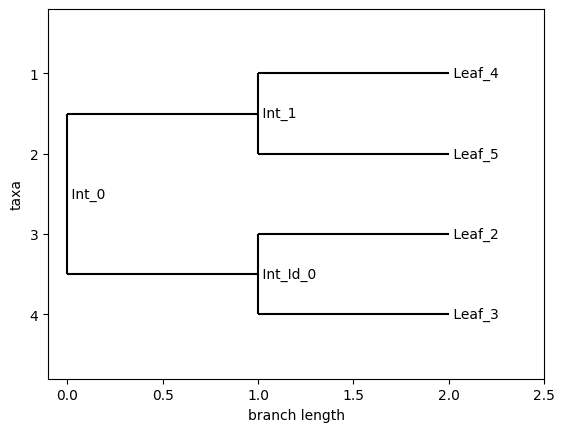

In [39]:
# Felsentstein algorithm
newick_tree = "((4,5),(2,3))"
L_tree = Phylo.read(StringIO(newick_tree), "newick")

# Change nodes names
for idx, clade in enumerate(L_tree.get_nonterminals()):
    id = 0
    if idx == 2:
        clade.name = "Int_Id_" + str(id)
        id += 1
    else:
        clade.name = "Int_" + str(idx) if idx > 0 else "Int_0" 

# Change leaves names
for idx, clade in enumerate(L_tree.get_terminals()):
    clade.name = "Leaf_" + clade.name 

Phylo.draw(L_tree)

L_net = Phylo.to_networkx(L_tree) # to graph

In [42]:
L_edges = []

for edge in L_net.edges():
    if edge[0].name.split("_")[1] == "Id" and edge[1].name.split("_")[1] == "Id":
        u = str(edge[0].name.split("_")[1]) + "_" + str(edge[0].name.split("_")[2])
        v = str(edge[1].name.split("_")[1]) + "_" + str(edge[1].name.split("_")[2])
    elif edge[0].name.split("_")[1] == "Id" and edge[1].name.split("_")[1] != "Id":
        u = str(edge[0].name.split("_")[1]) + "_" + str(edge[0].name.split("_")[2])
        v = str(edge[1].name.split("_")[1])
    elif edge[0].name.split("_")[1] != "Id" and edge[1].name.split("_")[1] == "Id":
        u = str(edge[0].name.split("_")[1])
        v = str(edge[1].name.split("_")[1]) + "_" + str(edge[1].name.split("_")[2])
    else:
        u = str(edge[0].name.split("_")[1])
        v = str(edge[1].name.split("_")[1])
    L_edges.append((u,v))

# Create a dictionary to store the father and son information
family_tree = {}

# Loop through the edges and update the dictionary
for father, son in L_edges:
    if father not in family_tree:
        family_tree[father] = []
    family_tree[father].append(son)

# Create a DataFrame from the dictionary
tree_df = pd.DataFrame.from_dict(family_tree, orient='index')

# Fill NaN values with empty strings
tree_df = tree_df.fillna('')

# Change column names
tree_df.columns = ['Child_1', 'Child_2']

print(tree_df)

     Child_1 Child_2
0          1    Id_0
1          4       5
Id_0       2       3


In [43]:
class TreeInference():
    """
    Encapsulates a tree and contains several methods to infer information about it
    
    tree_data: dataframe of nodes, daughters and branch length for an evolutionary tree
    leaf_values: bases for leaf nodes
    pi: prior probability that a state is at the root of the tree
    mu: mutation rate
    """
    def __init__(self, tree_data, leaf_values, pi):
        # Set parameters
        self.tree_data = tree_data.copy()
        self.leaf_values = leaf_values
        self.pi = np.array(pi)
        
        # Find IDs of internal nodes, all nodes and leaf nodes
        self.internal_node_ids = np.array(tree_data.index)
        self.all_node_ids = np.unique(np.concatenate((np.array(self.tree_data.index),
                                                      np.array(self.tree_data["Child_1"]),
                                                      np.array(self.tree_data["Child_2"]))))
        self.leaf_node_ids = list(set(self.all_node_ids) - set(self.internal_node_ids))
        
        # Count internal nodes and leaves for each row in tree_data 
        self.treeNodeCounts()

        # Set root node
        self.root_node = 0
        
        states = np.array(["A","G","C","T"])
        self.matrix_idx = dict(zip(states, range(len(states))))
        
        # Empty matrix of likelihood for each node
        self.L = np.full((len(self.all_node_ids), len(self.matrix_idx)), None)
        # Log likelihood of whole tree
        L_root = None
        

    """
    Calculates the number of internal nodes and leaves below each internal node.
    This works by recursively iterating down the child nodes from the original internal node until a
    leaf node is found, and then returning upwards counting the leaves and nodes.
    The new derived information is then added as two new columns at the end of the data.
    """
    def treeNodeCounts(self):
        n_nodes = np.array([])
        n_leaves = np.array([])

        # Set the number of internal nodes and leaves for each internal node row
        for n in self.internal_node_ids:
            num_nodes, num_leaves = self.checkNode(self.tree_data, n, self.internal_node_ids)
            n_nodes = np.append(n_nodes, num_nodes)
            n_leaves = np.append(n_leaves, num_leaves)

        # Add new information to dataframe
        self.tree_data["N_Internal"] = n_nodes
        self.tree_data["N_Leaves"] = n_leaves
                
    # Recursively find the number of internal nodes and leaves given a node ID
    def checkNode(self, tree_data, node_id, node_array):
        # Record the number of internal nodes and leaves below
        num_nodes = 0
        num_leaves = 0

        # Find the left and right daughter nodes
        daughter_1 = self.tree_data.loc[node_id]["Child_1"]
        daughter_2 = self.tree_data.loc[node_id]["Child_2"]

        # Check if found an internal node to the left
        if daughter_1 in node_array:
            # Recursively check nodes below
            d1_nodes, d1_leaves = self.checkNode(self.tree_data, daughter_1, node_array)
            num_nodes += d1_nodes + 1
            num_leaves += d1_leaves

        # Otherwise found a left leaf node
        else:
            num_leaves += 1

        # Check if found an internal node to the right
        if daughter_2 in node_array:
            d2_nodes, d2_leaves = self.checkNode(self.tree_data, daughter_2, node_array)
            num_nodes += d2_nodes + 1
            num_leaves += d2_leaves

        # Otherwise found a right leaf node
        else:
            num_leaves += 1

        return num_nodes, num_leaves
    
    # Calculate likelihood for an internal node
    def nodeLikelihood(self, node_n):
        # Find the left and right daughter nodes
        daughter_1 = self.tree_data.loc[node_n]["Child_1"]
        daughter_2 = self.tree_data.loc[node_n]["Child_2"]
        
        # Check if likelihood of left child node set
        if (self.L[int(daughter_1) - 1, 0] is None):
            # If not set then calculate child likelihood first
            self.nodeLikelihood(int(daughter_1))
        # Check if likelihood of right child node set
        if (self.L[int(daughter_2) - 1, 0] is None):
            self.nodeLikelihood(int(daughter_2))

        # Get conditional likelihood of child nodes
        d1_likelihood = self.L[int(daughter_1) - 1]
        d2_likelihood = self.L[int(daughter_2) - 1]

        ##### MATRIUS?
        
        # Calculate the likelihood of each state for the node
        left_prob = np.sum(A1 * d1_likelihood, axis = 1)
        right_prob = np.sum(A2 * d2_likelihood, axis = 1)
        self.L[node_n - 1] = np.multiply(left_prob, right_prob)
    
    # Run Felsenstein’s algorithm to calculate the log likelihood of the tree
    def calculateLikelihood(self):
        # Clear matrix of likelihood for each node
        self.L = np.full((len(self.all_node_ids), len(self.matrix_idx)), None)
        
        # Set likelihood of leaf states
        for leaf_n in self.leaf_node_ids:
            # Zero for non-matching base
            self.L[leaf_n - 1] = 0
            # One for matching base
            self.L[leaf_n - 1, self.matrix_idx[self.leaf_values[leaf_n]]] = 1
        
        for node_n in self.internal_node_ids:
            # Check likelihood has not been set
            if self.L[node_n - 1, 0] is None:
                # Calculate conditional likelihood of each state for the node
                self.nodeLikelihood(node_n)
                
        # Calculate likelihood of the whole tree
        self.L_root = math.log(sum(np.multiply(self.pi, self.L[self.root_node - 1])))
        
        return self.L_root

['000000',
 '000001',
 '000002',
 '000003',
 '000010',
 '000011',
 '000012',
 '000013',
 '000020',
 '000021',
 '000022',
 '000023',
 '000030',
 '000031',
 '000032',
 '000033',
 '000100',
 '000102',
 '000103',
 '000111',
 '000113',
 '000120',
 '000122',
 '000123',
 '000130',
 '000131',
 '000132',
 '000133',
 '000200',
 '000201',
 '000202',
 '000203',
 '000211',
 '000212',
 '000220',
 '000221',
 '000222',
 '000223',
 '000230',
 '000231',
 '000232',
 '000233',
 '000300',
 '000301',
 '000302',
 '000303',
 '000310',
 '000311',
 '000313',
 '000320',
 '000321',
 '000322',
 '000323',
 '000330',
 '000331',
 '000332',
 '000333',
 '001000',
 '001001',
 '001002',
 '001010',
 '001011',
 '001012',
 '001013',
 '001020',
 '001021',
 '001022',
 '001023',
 '001030',
 '001031',
 '001033',
 '001100',
 '001101',
 '001102',
 '001103',
 '001110',
 '001111',
 '001112',
 '001113',
 '001120',
 '001121',
 '001122',
 '001123',
 '001130',
 '001131',
 '001132',
 '001133',
 '001200',
 '001203',
 '001210',
 '001211',

In [189]:
if '0101' in u_i:
    print('ok')
else:
    print('not ok')

if '0000' in u_i:
    print('ok')
else:
    print('not ok')

not ok
ok


In [16]:
######################### DEBUGGING ############################

# # All possible (theoretical) occurrences of nucleotides in the leaves
# alphabet = [0, 1, 2, 3]
# combinations = itertools.product(alphabet, repeat=n_leaves)
# sorted_combinations = sorted(combinations)
# for i in range(len(sorted_combinations)):
#     sorted_combinations[i] = ''.join([str(s) for s in sorted_combinations[i]])

# # All possible (hidden) states of the internal nodes (i.e. indexes of columns of U)
# hidden_combinations = itertools.product(alphabet, repeat=n_int)
# sorted_hidden_combinations = sorted(hidden_combinations)
# for i in range(len(sorted_hidden_combinations)):
#     sorted_hidden_combinations[i] = ''.join([str(s) for s in sorted_hidden_combinations[i]])